In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 
import yfinance as yf 
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import objective_functions 
from pypfopt import expected_returns 

plt.style.use('seaborn-v0_8-darkgrid')  
import warnings
warnings.filterwarnings('ignore') 

In [3]:
pairs_selected = ['ARSSINFRA.NS-DHARSUGAR.NS', 'ASHOKLEY.NS-NATIONALUM.NS',
       'SUNDARAM.NS-SUPERSPIN.NS', 'CREST.NS-V2RETAIL.NS',
       'INDORAMA.NS-JINDALPHOT.NS', 'MADHAV.NS-NAHARINDUS.NS',
       'BIRLAMONEY.NS-EMKAY.NS', 'AMDIND.NS-BAGFILMS.NS',
       'ALPA.NS-MCDHOLDING.NS', 'ALKALI.NS-SALSTEEL.NS']   

In [4]:
pair_list = [col.split('-') for col in pairs_selected] 
symbols = [item for sublist in pair_list for item in sublist]   

In [5]:
start_date = '2015-01-01'
end_date = '2021-12-20'

test_start = '2022-01-01'
test_end = '2024-06-30' 

tickers = list(set(symbols))  
len(tickers)  

20

In [6]:
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
nifty = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']

data_test = yf.download(tickers, start=test_start, end=test_end)['Adj Close']
nifty_test = yf.download('^NSEI', start=test_start, end=test_end)['Adj Close'] 

[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed


In [7]:
def select_one(pairs_selected):
    final_tickers = [] 

    for pr in pairs_selected:
        a = list(pr.split('-')) 
        S1 = data[a[0]]
        S2 = data[a[1]] 

        ret1 = S1.pct_change().mean()
        ret2 = S2.pct_change().mean() 

        if ret1>ret2:
            final_tickers.append(a[0])
        else:
            final_tickers.append(a[1]) 
    return final_tickers

final_tickers = select_one(pairs_selected)             

In [8]:
final_tickers 

['DHARSUGAR.NS',
 'NATIONALUM.NS',
 'SUPERSPIN.NS',
 'V2RETAIL.NS',
 'JINDALPHOT.NS',
 'NAHARINDUS.NS',
 'EMKAY.NS',
 'AMDIND.NS',
 'ALPA.NS',
 'ALKALI.NS']

In [9]:
ticks_df = pd.DataFrame({'Unnamed: 0':final_tickers}) 
indices = pd.read_csv('Stocks_Industry.csv') 
merged_inner = pd.merge(indices, ticks_df, on='Unnamed: 0', how='inner') 
merged_inner 

,Unnamed: 0,Industry
0,DHARSUGAR.NS,Sugar
1,EMKAY.NS,Finance
2,JINDALPHOT.NS,Transport
3,SUPERSPIN.NS,Textiles
4,NAHARINDUS.NS,Textiles
5,NATIONALUM.NS,Aluminium
6,V2RETAIL.NS,NaN
7,ALKALI.NS,Metals
8,ALPA.NS,Textiles
9,AMDIND.NS,Packaging


In [10]:
final_df = data[final_tickers] 
final_df.head(3) 

Ticker,DHARSUGAR.NS,NATIONALUM.NS,SUPERSPIN.NS,V2RETAIL.NS,JINDALPHOT.NS,NAHARINDUS.NS,EMKAY.NS,AMDIND.NS,ALPA.NS,ALKALI.NS
Date,,,,,,,,,,
2015-01-01,16.9,31.903341,7.75,41.099998,108.557587,56.260658,47.935379,22.099163,13.30,16.869980
2015-01-02,17.6,31.559679,7.80,41.400002,110.684677,57.684357,47.568409,22.146086,13.40,17.385094
2015-01-05,17.0,30.614599,7.85,40.299999,113.875313,57.340706,48.118866,22.005327,14.05,18.372395


In [11]:
returns = final_df.pct_change() 
returns.dropna(inplace=True)
returns.head(3) 

Ticker,DHARSUGAR.NS,NATIONALUM.NS,SUPERSPIN.NS,V2RETAIL.NS,JINDALPHOT.NS,NAHARINDUS.NS,EMKAY.NS,AMDIND.NS,ALPA.NS,ALKALI.NS
Date,,,,,,,,,,
2015-01-02,0.041420,-0.010772,0.006452,0.007299,0.019594,0.025305,-0.007656,0.002123,0.007519,0.030534
2015-01-05,-0.034091,-0.029946,0.006410,-0.026570,0.028826,-0.005957,0.011572,-0.006356,0.048508,0.056790
2015-01-06,-0.005882,-0.036483,-0.057325,-0.035980,-0.034023,-0.021404,-0.021926,-0.017058,-0.007117,-0.056075


In [12]:
mu = expected_returns.mean_historical_return(final_df) 
S = risk_models.sample_cov(final_df) 

In [13]:
ef = EfficientFrontier(mu, S, weight_bounds=(0.01,0.20)) 
ef.add_objective(objective_functions.L2_reg, gamma=0.1) 
weights = ef.max_sharpe() 
cleaned_weights = ef.clean_weights() 

In [14]:
cleaned_weights 

OrderedDict([('DHARSUGAR.NS', 0.01),
             ('NATIONALUM.NS', 0.2),
             ('SUPERSPIN.NS', 0.01),
             ('V2RETAIL.NS', 0.2),
             ('JINDALPHOT.NS', 0.13099),
             ('NAHARINDUS.NS', 0.02431),
             ('EMKAY.NS', 0.0147),
             ('AMDIND.NS', 0.01),
             ('ALPA.NS', 0.2),
             ('ALKALI.NS', 0.2)])

In [15]:
ef.portfolio_performance(verbose=True) 

Expected annual return: 20.6%
Annual volatility: 32.5%
Sharpe Ratio: 0.57


(0.20587293321430444, 0.32453190184340136, 0.5727416385215498)

#### Pie Chart for portfolio weights

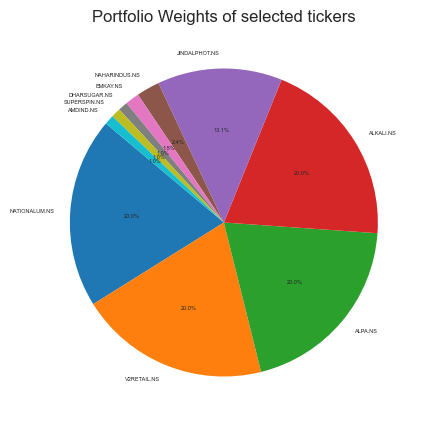

In [27]:
weight_series = pd.Series(cleaned_weights).sort_values(ascending=False)
plt.figure(figsize=(5,5)) 
weight_series.plot(kind='pie', autopct='%1.1f%%', startangle=140, textprops={'fontsize':4},
                    title='Portfolio Weights of selected tickers') 
plt.axis('off') 
plt.savefig('piechart.png')
plt.show() 

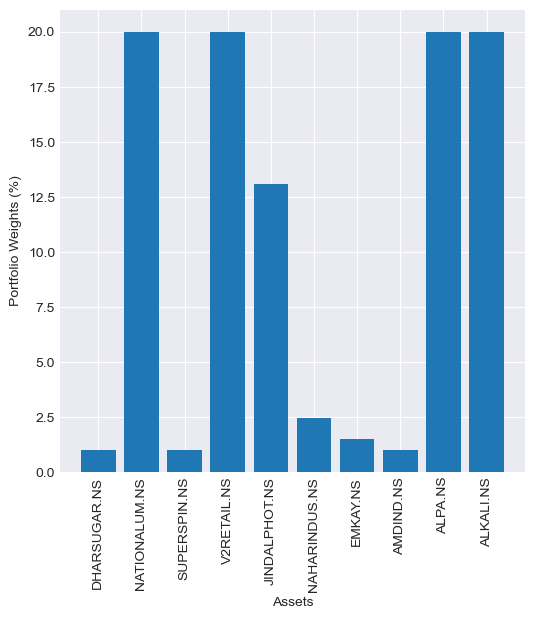

In [17]:
plt.figure(figsize=(6,6)) 

weight_values = list(cleaned_weights.values())
weights_percentage = [w*100 for w in weight_values]

plt.bar(cleaned_weights.keys(), weights_percentage)
plt.xlabel('Assets')
plt.ylabel('Portfolio Weights (%)') 
plt.xticks(rotation=90)
plt.show() 

### Returns for Buy and Hold strategy for a period of 2021-2023

In [18]:
test_df = data_test[final_tickers]  

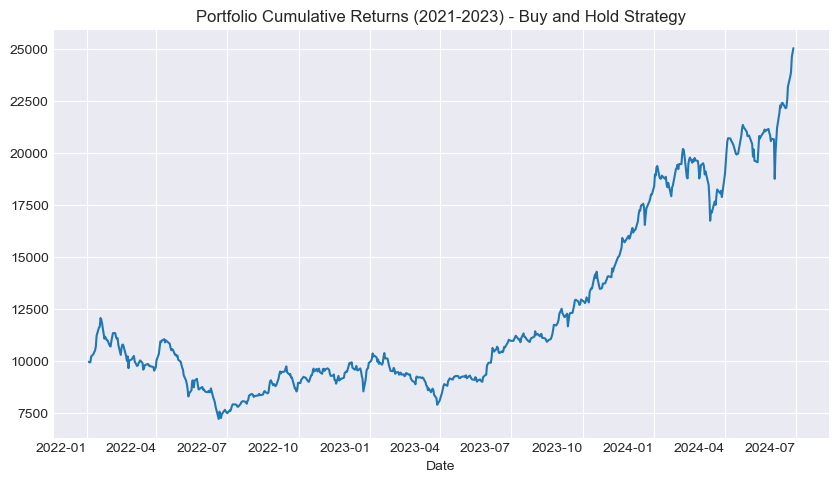

In [19]:
# Calculate daily returns for the period 2021-2023
daily_returns_bnh = test_df.pct_change() 
initial_capital = 10000

# Calculate portfolio returns using the optimized weights from 2015-2020
portfolio_returns_bnh = daily_returns_bnh.dot(pd.Series(cleaned_weights)) 
cumulative_returns_bnh = (1+portfolio_returns_bnh).cumprod()*initial_capital 

# Plot cumulative returns for the period 2021-2023
cumulative_returns_bnh.plot(figsize=(10,6), title='Portfolio Cumulative Returns (2021-2023) - Buy and Hold Strategy')
plt.xticks(rotation=0)
plt.show() 

### Returns for Trading strategy for a period of 2021-2023

Trading Strategy defined from moving average and z-scores

In [20]:
def strategy(test_df, weights, initial_capital=10000, window1=1, window2=30):
    if window1 == 0 or window2 == 0:
        return 0
    
    # Initialize data structures
    money_list = pd.Series(index=test_df.index)
    money_list.iloc[0] = initial_capital
    
    allocation = {asset: initial_capital * weight for asset, weight in weights.items()}
    initial_allocation = allocation.copy()  # Store initial allocation
    df_portfolio = pd.DataFrame(index=test_df.index) 
    final_values = {}  # Dictionary to store final values of each stock
    portfolio_value = [] # To store portfolio values over time 

    # Process each stock
    for stock in test_df.columns:
        price = test_df[stock] 
        ma1 = price.rolling(window=window1, center=False).mean() 
        ma2 = price.rolling(window=window2, center=False).mean() 
        std = price.rolling(window=window2, center=False).std() 

        zscore = (ma1 - ma2) / std 

        # Initialize trading variables
        stock_count, profit, position_entered, first_price = 0, 0, 0, 0

        for i in range(len(price)):

            current_value = sum(allocation[stock] for stock in allocation) + stock_count * price[i]
            portfolio_value.append(current_value)
            money_list.iloc[i] = current_value 

            if zscore[i] < -1.5 and allocation[stock] > price[i] and position_entered == 0: # Buy
                stock_count = int(allocation[stock] / price[i]) 
                first_price = price[i] 
                allocation[stock] -= stock_count * price[i]
                position_entered = 1 

            elif zscore[i] > 1.5 and allocation[stock] > price[i] and position_entered == 1: # Sell    
                profit = stock_count * (price[i] - first_price) 
                allocation[stock] += stock_count * price[i] + profit 
                stock_count = 0
                position_entered = 0

            elif abs(zscore[i]) < 0.1 and position_entered == 1: # Sell and clear
                profit = stock_count * (price[i] - first_price) 
                allocation[stock] += stock_count * price[i] + profit
                stock_count = 0
                position_entered = 0  

            df_portfolio.loc[price.index[i], stock] = (allocation[stock] + price.iloc[i] * stock_count).round(2) 

        # Calculate final value of the stock
        final_value = (allocation[stock] + price.iloc[-1] * stock_count).round(2)
        final_values[stock] = final_value

    df_portfolio["Portfolio_rets"] = df_portfolio.sum(axis=1) 
    df_portfolio.round(decimals = 4).dropna()         
        
    # Calculate total portfolio value
    total_value = sum(final_values.values())
    print(f"Total portfolio value at the end of the period: ${total_value:.4f}")

    portfolio_ret = pd.DataFrame(index=test_df.columns)  
    portfolio_ret['Initial_allocation'] = portfolio_ret.index.map(initial_allocation)  
    portfolio_ret['Final Values'] = portfolio_ret.index.map(final_values)  

    return portfolio_ret, df_portfolio   

portfolio_ret, portfolio_df = strategy(test_df, cleaned_weights)  

Total portfolio value at the end of the period: 31961.4800


In [21]:
portfolio_ret 

,Initial_allocation,Final Values
Ticker,,
DHARSUGAR.NS,100.0,40.00
NATIONALUM.NS,2000.0,1150.26
SUPERSPIN.NS,100.0,72.00
V2RETAIL.NS,2000.0,8509.55
JINDALPHOT.NS,1309.9,960.00
NAHARINDUS.NS,243.1,199.62
EMKAY.NS,147.0,218.48
AMDIND.NS,100.0,226.75
ALPA.NS,2000.0,8860.58


In [22]:
portfolio_df.tail(1) 

,DHARSUGAR.NS,NATIONALUM.NS,SUPERSPIN.NS,V2RETAIL.NS,JINDALPHOT.NS,NAHARINDUS.NS,EMKAY.NS,AMDIND.NS,ALPA.NS,ALKALI.NS,Portfolio_rets
Date,,,,,,,,,,,
2024-06-28,40.0,1150.26,72.0,8509.55,960.0,199.62,218.48,226.75,8860.58,11724.24,31961.48


In [24]:
# Total return
print('='*20,'Statistics for Buy and Hold Strategy (2022-2024)','='*20)
print() 
total_return_bnh = (cumulative_returns_bnh.iloc[-1])/initial_capital - 1
print(f'Initial Investment : ${initial_capital}') 
print(f'Portfolio value at the end of time frame: ${(cumulative_returns_bnh.iloc[-1]).round(2)}')   
print(f'Profit made : ${(cumulative_returns_bnh.iloc[-1]-initial_capital).round(2)}') 
print() 
print(f'Total Returns : {total_return_bnh:.2%}') 

# Annualized return
annualized_return_bnh = (1 + total_return_bnh) ** (1/3) - 1  # 3 years
print(f'Annualized Returns : {annualized_return_bnh:.2%}')

# Annualized volatility
annualized_volatility_bnh = np.std(portfolio_returns_bnh)*np.sqrt(252) 
print(f'Annualized Volatility : {annualized_volatility_bnh:.2%}')

# Sharpe Ratio
risk_free_rate = 0.01   # Assuming risk free rate of 1%
sharpe_ratio_bnh = (annualized_return_bnh-risk_free_rate)/annualized_volatility_bnh
print(f'Sharpe Ratio : {sharpe_ratio_bnh:.2f}') 

print() 

print('='*20,'Statistics for Trading Strategy (2022-2024)','='*20) 
print() 
total_return_str = (portfolio_df['Portfolio_rets'].iloc[-1])/initial_capital-1 
print(f'Initial Investment : ${initial_capital}') 
print(f'Portfolio value at the end of time frame: ${(portfolio_df['Portfolio_rets'].iloc[-1]).round(2)}')   
print(f'Profit made : ${(portfolio_df['Portfolio_rets'].iloc[-1]-initial_capital).round(2)}') 
print() 
print(f'Total Returns : {total_return_str:.2%}') 

portfolio_returns_str = portfolio_df['Portfolio_rets'].pct_change().dropna()

# Annualized return
annualized_return_str = (1 + total_return_str) ** (1/3) - 1  # 3 years
print(f'Annualized Returns : {annualized_return_str:.2%}')

# Annualized volatility
annualized_volatility_str = np.std(portfolio_returns_str)*np.sqrt(252) 
print(f'Annualized Volatility : {annualized_volatility_str:.2%}')

# Sharpe Ratio
risk_free_rate = 0.01   # Assuming risk free rate of 1%
sharpe_ratio_str = (annualized_return_str-risk_free_rate)/annualized_volatility_str
print(f'Sharpe Ratio : {sharpe_ratio_str:.2f}')  

==================== Statistics for Buy and Hold Strategy (2022-2024) ====================

Initial Investment : 10000$
Portfolio value at the end of time frame: 25028.38$
Profit made : 15028.38$

Total Returns : 150.28%
Annualized Returns : 35.77%
Annualized Volatility : 29.53%
Sharpe Ratio : 1.18

==================== Statistics for Trading Strategy (2022-2024) ====================

Initial Investment : 10000$
Portfolio value at the end of time frame: 31961.48$
Profit made : 21961.48$

Total Returns : 219.61%
Annualized Returns : 47.30%
Annualized Volatility : 27.90%
Sharpe Ratio : 1.66


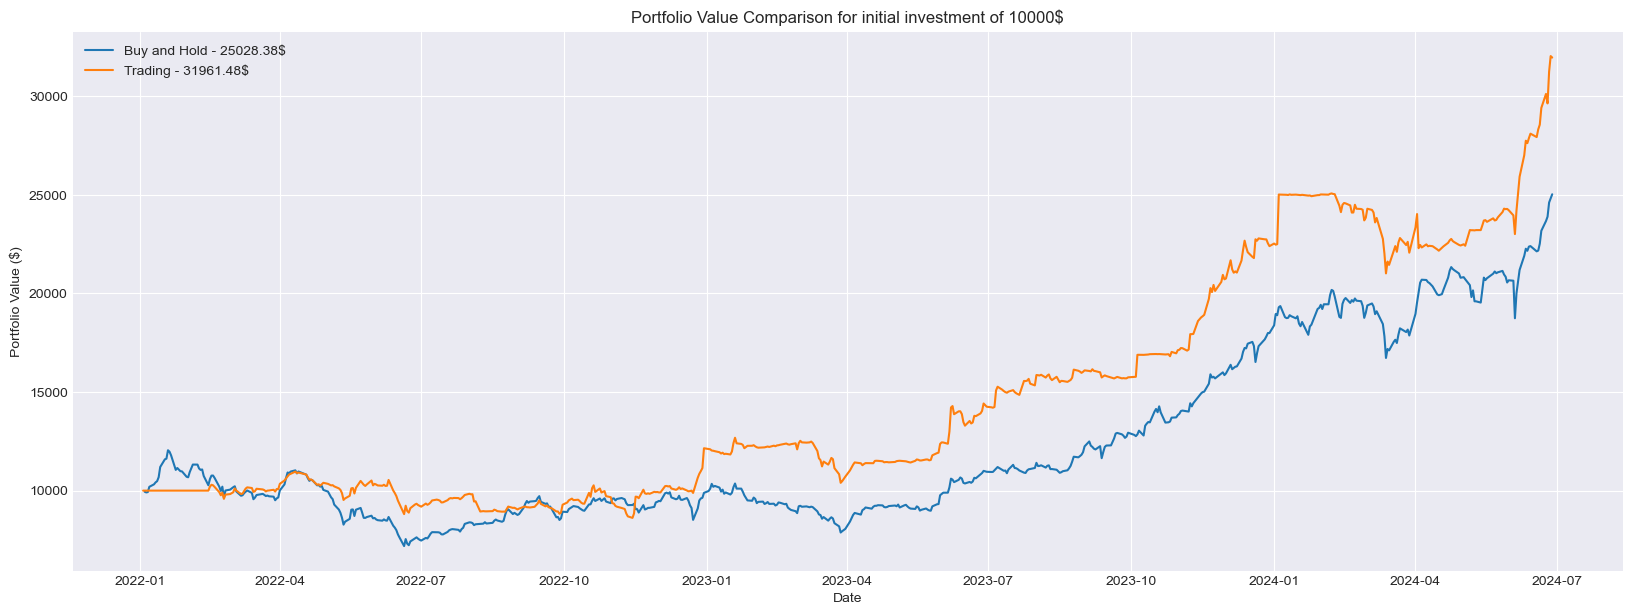

In [29]:
plt.figure(figsize=(20,7))

plt.plot(test_df.index, cumulative_returns_bnh, label=f'Buy and Hold - ${(cumulative_returns_bnh.iloc[-1]).round(2)}')
plt.plot(test_df.index, portfolio_df['Portfolio_rets'], label=f'Trading - ${(portfolio_df['Portfolio_rets'].iloc[-1]).round(2)}')

plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Comparison for initial investment of $10000')
plt.legend()  
plt.savefig('comparison.png')
plt.show() 